In [ ]:
# !pip install arviz
# !pip install pymc3==3.8

In [201]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import Image
from IPython.core.pylabtools import figsize
from matplotlib import gridspec


In [202]:
df1 = pd.read_csv('preprocessed.csv',sep = ',')
df1.info()
df1['units_sold'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Columns: 123 entries, Unnamed: 0 to country__VE
dtypes: float64(12), int64(111)
memory usage: 1.5 MB


count      1573.000000
mean       4339.052765
std        9356.517210
min          10.000000
25%         100.000000
50%        1000.000000
75%        5000.000000
max      100000.000000
Name: units_sold, dtype: float64

In [203]:
print(len(df1[df1['units_sold'] == 10]))
print(len(df1[df1['units_sold'] == 100]))
print(len(df1[df1['units_sold'] == 1000]))
print(len(df1[df1['units_sold'] == 5000]))
print(len(df1[df1['units_sold'] == 10000]))

63
509
405
217
177


In [204]:
#Rating Count 0.90
#Merchant Rating Count: 0.27
#Merchant pop proc :0.25
#product_color > 轉成 one hot
#product_variation_size_id > 轉成 one hot
#origin_country > 轉成 one hot

def format_data(df):
    print(df.info())
    # Targets are final grade of student
    labels = df['units_sold']
    normalized_df=( labels-labels.mean())/ labels.std()
    # print(normalized_df.head())
    # print(labels.head())
    # Drop the school and the grades from features

    tmp = df[['rating','merchant_rating_count','merch_pop_proc','price','retail_price']]

    # One-Hot Encoding of Categorical Variables
    # df = pd.get_dummies(df)
    # print(tmp.head())
    # tmp['correct_label'] = list(normalized_df)
    
    # most_correlated = tmp.corr().abs()['y'].sort_values(ascending=False)
    
    # Keep correlations greater than 0.2 in absolute value
    # most_correlated = most_correlated[most_correlated >= 0.2][1:]
    
    # df = df.ix[:, most_correlated.index]
    
    # Already encode the higher education column in `higher_yes`
    # df = df.drop(columns = 'higher_no')
    
    # Split into training/testing sets with 25% split
    # X_train, X_test, y_train, y_test = train_test_split(df, normalized_df, test_size = 0.2)
    
    # Return the training and testing data
    # return tmp, normalized_df
    return tmp.iloc[:1473, :], tmp.iloc[1473:, :], normalized_df.iloc[:1473], normalized_df.iloc[1473:]

In [205]:
# get train data
X_train_math,X_test_math,y_train_math, y_test_math = format_data(df1)

X_test_math.head()
#get predict data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Columns: 123 entries, Unnamed: 0 to country__VE
dtypes: float64(12), int64(111)
memory usage: 1.5 MB
None


,rating,merchant_rating_count,merch_pop_proc,price,retail_price
1473,4.67,2805,0.002139,5.00,9
1474,4.29,32318,0.005508,3.72,11
1475,3.74,139223,0.010372,3.81,59
1476,3.36,10600,0.007830,4.93,5
1477,4.05,5816,0.254298,11.00,10


In [206]:
y_test_math.head()

1473   -0.453059
1474   -0.356869
1475    0.070640
1476   -0.356869
1477    0.605027
Name: units_sold, dtype: float64

In [207]:
# Set number of draws for sampling
NDRAWS = 2000

In [208]:
formula = 'y ~ ' + ' + '.join(['%s' % variable for variable in X_train_math.columns[:]])

In [209]:
# Need to put 'y' in the data
X_train_math['y'] = list(y_train_math)
formula
# y_train_math

'y ~ rating + merchant_rating_count + merch_pop_proc + price + retail_price'

In [211]:
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Making the model only requires specifying the formula and the data
    pm.GLM.from_formula(formula, X_train_math, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(init="adapt_diag",draws=NDRAWS, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, retail_price, price, merch_pop_proc, merchant_rating_count, rating, Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:17<00:00, 170.79it/s]


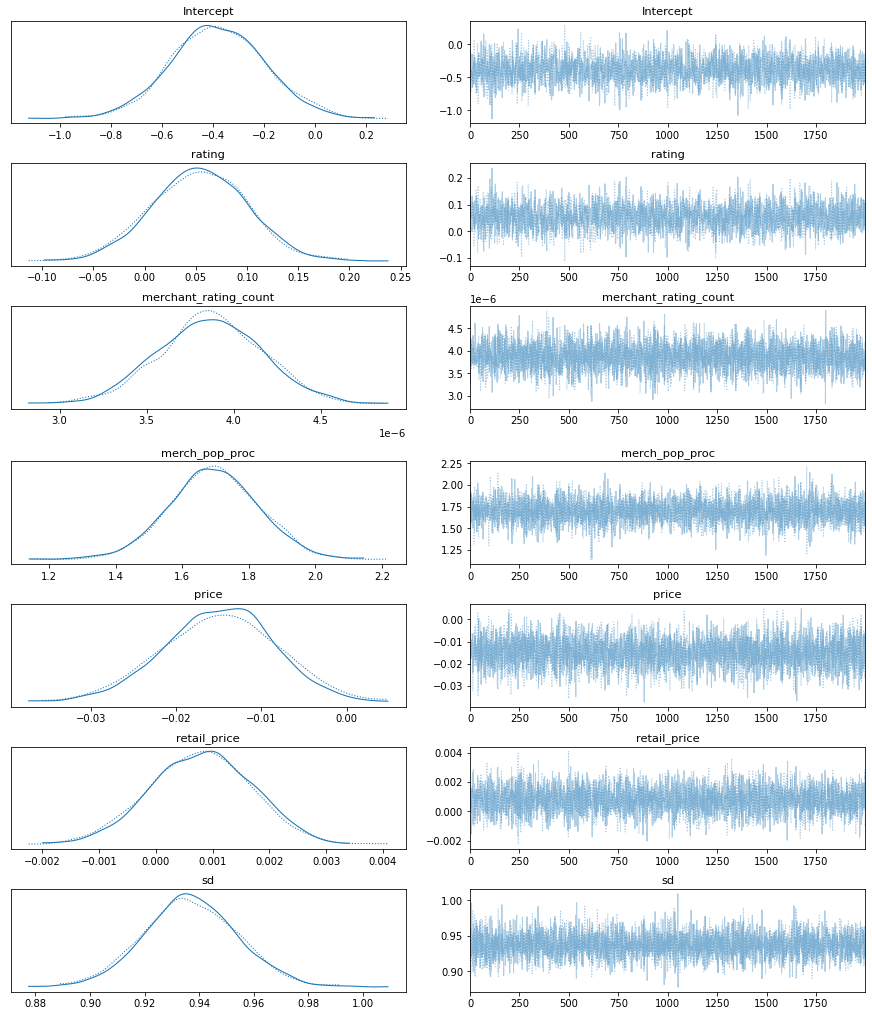

In [212]:
pm.traceplot(normal_trace);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b729a6d30>],
      dtype=object)

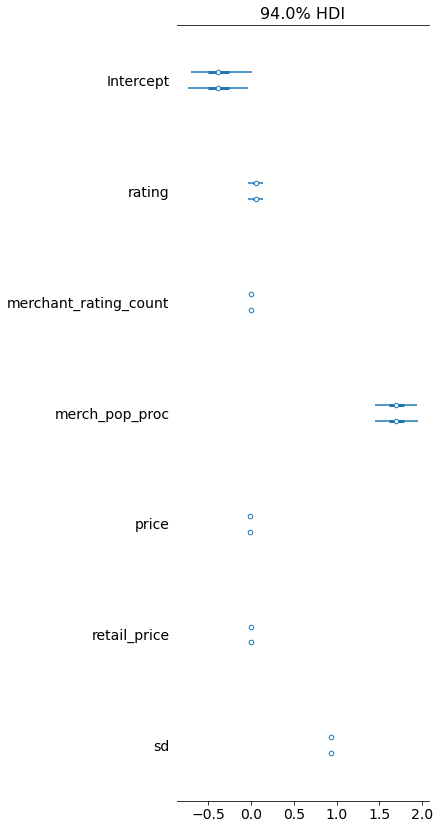

In [213]:
pm.forestplot(normal_trace)

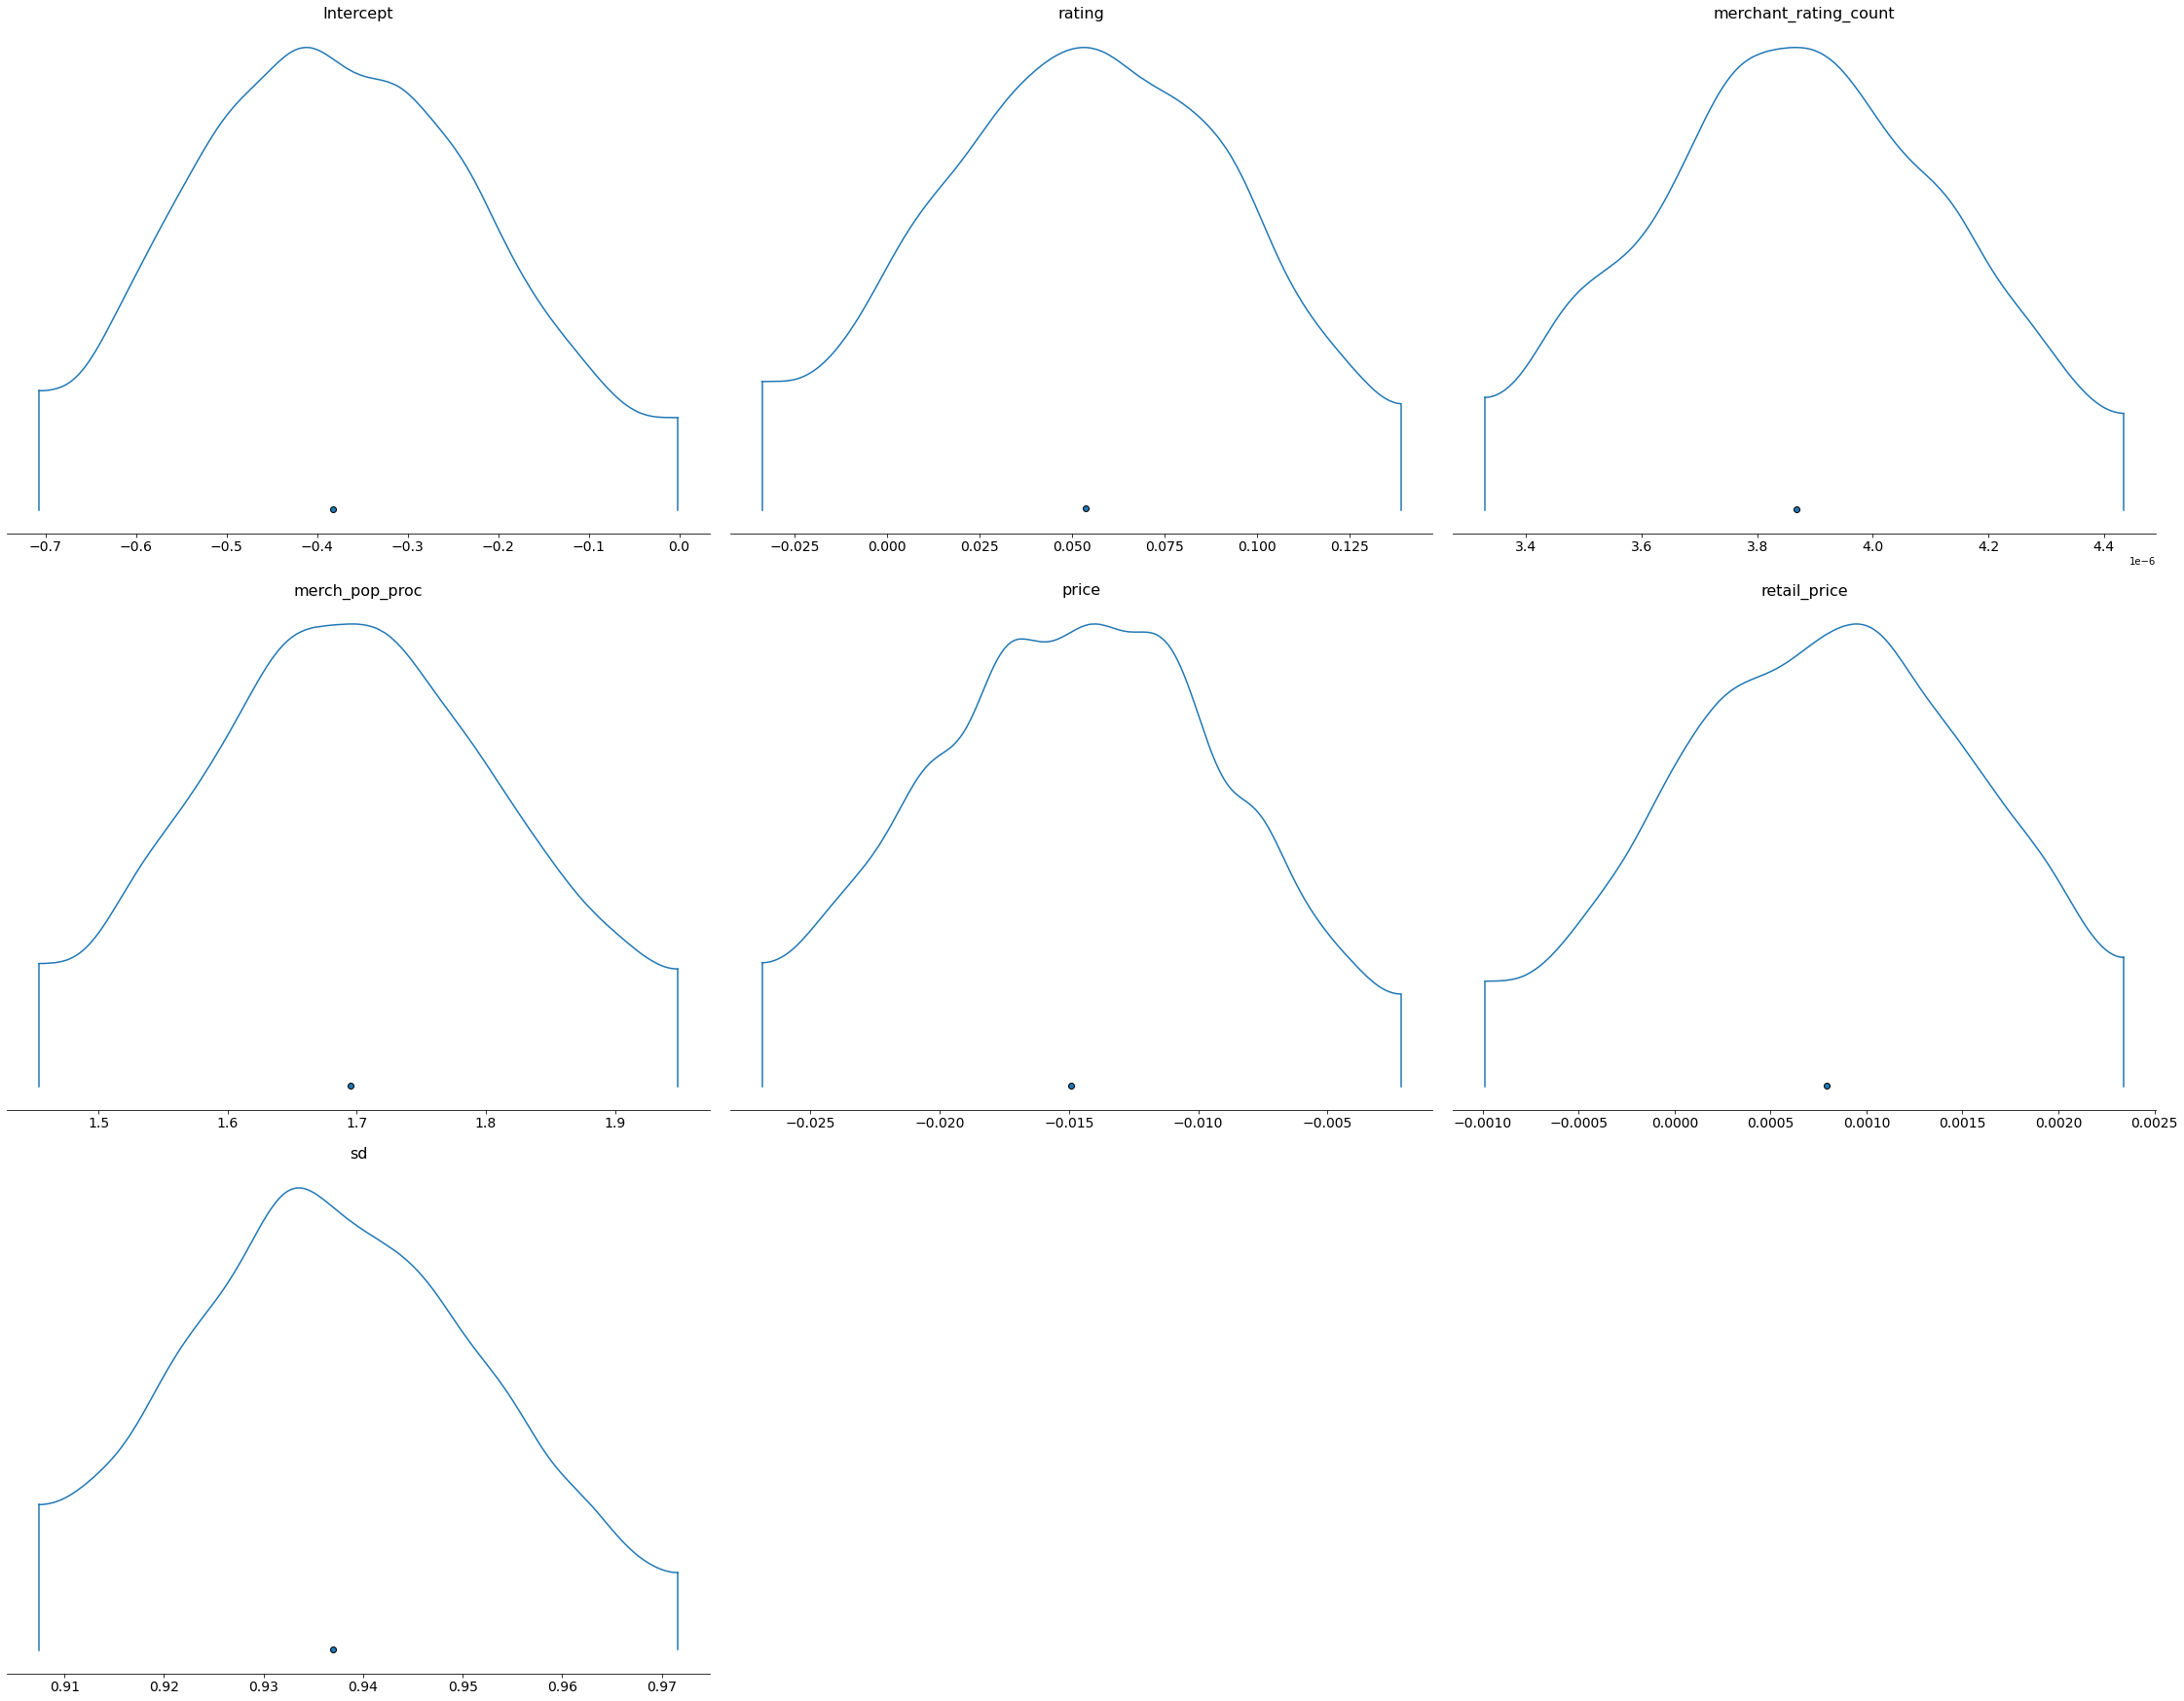

In [214]:
pm.densityplot(normal_trace);

In [215]:
for variable in normal_trace.varnames:
    print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
                                                                np.mean(normal_trace[variable])))

Variable: Intercept       Mean weight in model: -0.3822
Variable: rating          Mean weight in model: 0.0537
Variable: merchant_rating_count Mean weight in model: 0.0000
Variable: merch_pop_proc  Mean weight in model: 1.6951
Variable: price           Mean weight in model: -0.0149
Variable: retail_price    Mean weight in model: 0.0008
Variable: sd_log__        Mean weight in model: -0.0653
Variable: sd              Mean weight in model: 0.9369


In [216]:
model_formula = 'y ~ '
for variable in normal_trace.varnames:
    model_formula += '(%0.4f * %s) + ' % (np.mean(normal_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-2])

'y ~ (-0.3822 * Intercept) + (0.0537 * rating) + (0.0000 * merchant_rating_count) + (1.6951 * merch_pop_proc) + (-0.0149 * price) + (0.0008 * retail_price) + (-0.0653 * sd_log__) + (0.9369 * sd)'

In [227]:
from sklearn.metrics import mean_squared_error
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results=None):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns
    X_test = X_test.loc[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
    
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    rmse = np.sqrt(mean_squared_error(results['estimate'], actual))
    mape = np.median(abs(errors) / actual)
    
    print('Model RMSE: {:.4f}\nModel MAPE: {:.4f}'.format(rmse, mape))

    # Plot the observations and predictions
    figsize(10, 10)
    plt.scatter(results.index, actual, label = 'Observed', color = 'blue')
    plt.scatter(results.index, results['estimate'], label = 'Estimate', color = 'red')
    plt.legend(prop={'size': 14}); plt.xlabel('Index'); plt.ylabel('Grade');
    plt.title('Observed and Estimated Values')
    plt.show()
    
    # # Add the results to the comparison dataframe
    # model_results.ix['Bayesian LM', :] = [rmse, mape]
    
    
    # # Plot root mean squared error of all models
    # plt.figure(figsize=(12, 6))
    # ax = plt.subplot(1, 2, 1)
    # model_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b', ax = ax)
    # plt.title('Model RMSE Comparison'); plt.ylabel('RMSE')

    # # Plot median absolute percentage error of all models
    # ax = plt.subplot(1, 2, 2)
    # model_results.sort_values('mape', ascending = True).plot.bar(y = 'mape', color = 'r', ax = ax)
    # plt.title('Model MAPE Comparison'); plt.ylabel('MAPE'); 
    # plt.tight_layout()
    # plt.show();
    
    return results

Model RMSE: 0.5798
Model MAPE: -0.4399


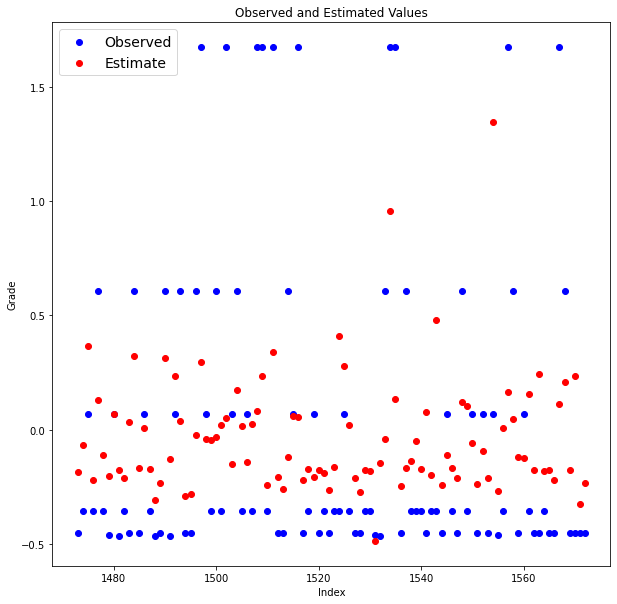

In [228]:
results = evaluate_trace(normal_trace, X_train_math, X_test_math, y_train_math, y_test_math, None)